In [20]:
!pip install tensorflow matplotlib numpy sickit-learn --user -U

  Using cached tensorflow-2.13.1-cp38-cp38-win_amd64.whl (1.9 kB)
  Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl (14.9 MB)


ERROR: Could not find a version that satisfies the requirement sickit-learn
ERROR: No matching distribution found for sickit-learn


In [39]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

print(tf .__version__) # verifica veloce versione TF

2.13.0


In [40]:
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()
y_train_full = y_train_full.flatten()
y_test_full = y_test_full.flatten()

# CIFAR-10 label map ufficiale
label_names = ['airplane','automobile','bird','cat' ,'deer' ,'dog' ,'frog' ,'horse' ,'ship' , 'truck' ]
cat_label, dog_label = 3, 5

# Filtra solo gatti e cani
train_mask = (y_train_full == cat_label) | (y_train_full == dog_label)
test_mask = (y_test_full == cat_label) | (y_test_full == dog_label)

X_train_cd = X_train_full[train_mask]
y_train_cd = y_train_full[train_mask]
X_test_cd = X_test_full[test_mask]
y_test_cd = y_test_full[test_mask]

# Rimappa etichette: cat->0, dog->1
y_train_cd =(y_train_cd == dog_label).astype(np.int32)
y_test_cd = (y_test_cd == dog_label).astype(np.int32)

X_train_cd. shape, X_test_cd.shape, np.bincount(y_train_cd), np.bincount(y_test_cd)

((10000, 32, 32, 3),
 (2000, 32, 32, 3),
 array([5000, 5000], dtype=int64),
 array([1000, 1000], dtype=int64))

In [45]:
from pathlib import Path
import os, ssl, certifi, urllib. request

# 1) assicura la cache Keras standard
os.environ.setdefault("KERAS_HOME", str(Path.home() / ".keras"))

# 2) punta esplicitamente al bundle CA di certifi
caf = certifi.where()
os.environ["SSL_CERT_FILE"] = caf
os.environ ["REQUESTS_CA_BUNDLE"] = caf

# 3) crea un contesto SSL verificato con certifi e usalo ovunque
ctx = ssl.create_default_context(cafile=caf)
ssl ._create_default_https_context = lambda *a, **k: ctx # usato da urllib di default

# 4) forza anche l'opener di urllib a usare il nostro contesto (usato da keras.utils.get_file)
urllib. request.install_opener(
    urllib. request.build_opener(urllib. request.HTTPSHandler(context=ctx))
)

print("KERAS_HOME =", os.environ ["KERAS_HOME"])
print("CA bundle =", caf)
print("SSL patch= 0K")

KERAS_HOME = C:\Users\net.LABXX-XX\.keras
CA bundle = C:\ProgramData\Anaconda3\lib\site-packages\certifi\cacert.pem
SSL patch= 0K


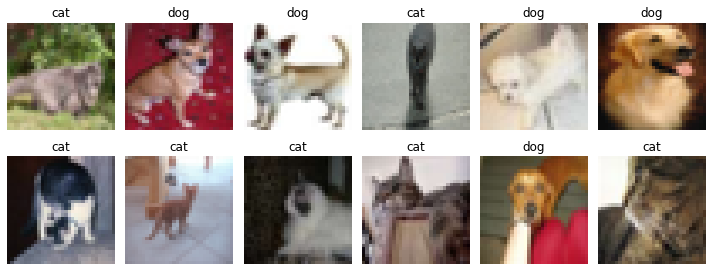

In [46]:
def show_examples(X, y, class_names=('cat','dog'), n=12):
    plt.figure(figsize=(10, 4))
    idx = np.random.choice(len(X), size=n, replace=False)
    for i, j in enumerate(idx):
        plt.subplot(2, n//2, i+1)
        plt.imshow(X[j])
        plt.title(class_names[y[j]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_examples(X_train_cd, y_train_cd, n=12)

In [47]:
SAMPLES_PER_CLASS_TRAIN = 3000 # es: 3000 cat + 3000 dog = 6000
SAMPLES_PER_CLASS_TEST = 500

def subsample_balanced(X, y, samples_per_class) :
    if samples_per_class is None:
        return X, y
    X_out, y_out = [], []
    for cls in [0,1]:
        idx = np.where(y == cls) [0]
        idx = np.random. choice(idx, size=min(samples_per_class, len(idx) ), replace=False)
        X_out.append(X[idx])
        y_out.append(y[idx] )
    return np.concatenate(X_out), np.concatenate(y_out)

X_train_small, y_train_small = subsample_balanced(X_train_cd, y_train_cd, SAMPLES_PER_CLASS_TRAIN)
X_test_small, y_test_small = subsample_balanced(X_test_cd, y_test_cd, SAMPLES_PER_CLASS_TEST)

# Mescola il training
perm = np. random. permutation(len(X_train_small) )
X_train_small, y_train_small = X_train_small[perm], y_train_small[perm]

# Normalizzazione [0,1]
X_train_small = X_train_small.astype('float32') / 255.0
X_test_small = X_test_small.astype('float32') / 255.0

In [48]:
def build_cnn(input_shape=(32,32,3)):
    model = models. Sequential( [
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same' ),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers. Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid') # output binario
    ])

    model. compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn()
model. summary ( )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

NameError: name 'model' is not defined